# CS520 S20 Group2 Data Curation Project Demo

## Road ahead

* [Step 1](#1): Download the original dataset 
* [Step 2](#2): **Extract** a list of `.h5` file paths
* [Step 3](#3): Extract fields of interest from `.h5` files
* [Step 4](#4): **ETL** world & US cities lat&lng master data
* [Step 5](#5): **Transform** and clean data
    * [Step 5.1](#51): Convert data types
    * [Step 5.2](#52): Detect constraint violations
    * [Step 5.3](#53): Detect missing values
    * [Step 5.4](#54): Impute missing values
* [Step 6](#6): **Load** the cleaned dataset

In [3]:
import requests
import os
import gzip
import tarfile
import sys
import glob
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

<a id='1'></a>
## Step 1: Download original dataset

In [2]:
def download_data(url='http://static.echonest.com/millionsongsubset_full.tar.gz', 
            	  file='millionsongsubset_full.tar.gz', 
            	  dst_dir='./data'):
    """
    Download the subset of million song dataset from the official website:
    http://millionsongdataset.com/pages/getting-dataset/#subset to the data dir.
    Decompress the gz file to the MillionSongSubset folder under current directory.
    
    # arguments
        url: url to the dataset
        file: file name of the dataset
        dst_dir: local file path to the dataset
    """
    # Make a data dir in local disk
    if os.path.isdir(dst_dir):
        print(dst_dir, 'exists')
    else:
        os.mkdir(dst_dir)

        
    # Download the large dataset in chunks
    if not os.path.isfile(os.path.join(dst_dir, file)):
        r = requests.get(url, stream=True)
        with open('data/millionsongsubset_full.tar.gz', 'wb') as f:
            print('Downloading ' + file + '...')
            i = 1
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    sys.stdout.write("\rProgress: {} KBs downloaded".format(1024 * i))
                    sys.stdout.flush()
                    i += 1
            print(file + ' downloaded')
    else:
        print('millionsongsubset_full.tar.gz exists')

    # Decompress the gz file to current folder
    subset_path = 'MillionSongSubset'
    if not os.path.isdir(subset_path):
        print('Decompressing gz file...')
        tf = tarfile.open(os.path.join(dst_dir, file))
        tf.extractall()
        tf.close()
        print('Decompressing completed')
    else:
        print(subset_path, 'exists')

In [3]:
download_data()

./data exists
Progress: 1989667840 KBs downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: 1992710144 KBs downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: 1994481664 KBs downloaded

<a id='2'></a>
## Step 2: Extract a list of file paths

In [4]:
def get_files(file_path):
    """
    From current directory, go through all subdirectories and find all .h5 fiels.
    Return all absolute paths in a list.
    """
    all_files = []
    for root, dirs, files in os.walk(file_path):
        files = glob.glob(os.path.join(root,'*.h5'))
        for f in files:
            all_files.append(os.path.abspath(f))
    return all_files

In [5]:
songs_path = "./MillionSongSubset/data"
song_files = get_files(songs_path)
print('# of files:', len(song_files))
print('file path:', song_files[0])

# of files: 10000
file path: H:\IIT\CS520\Data Curation Project\cs520-s20-group-2\MillionSongSubset\data\A\A\A\TRAAAAW128F429D538.h5


In [12]:
# Open a file
print('File path:', song_files[0])
f = pd.HDFStore(song_files[0], mode='r')
print('File directory:', f.root)
print(f.root.analysis)
print(f.root.analysis.songs.cols)
print(f.root.metadata)
print(f.root.metadata.songs.cols)
print(f.root.musicbrainz)
print(f.root.musicbrainz.songs.cols)

File path: H:\IIT\CS520\Data Curation Project\cs520-s20-group-2\MillionSongSubset\data\A\A\A\TRAAAAW128F429D538.h5
File directory: / (RootGroup) 'H5 Song File'
/analysis (Group) 'Echo Nest analysis of the song'
/analysis/songs.cols (Cols), 31 columns
/metadata (Group) 'metadata about the song'
/metadata/songs.cols (Cols), 20 columns
/musicbrainz (Group) 'data about the song coming from MusicBrainz'
/musicbrainz/songs.cols (Cols), 2 columns


In [13]:
f.root.analysis.songs.cols

/analysis/songs.cols (Cols), 31 columns
  analysis_sample_rate (Column(1,), int32)
  audio_md5 (Column(1,), |S32)
  danceability (Column(1,), float64)
  duration (Column(1,), float64)
  end_of_fade_in (Column(1,), float64)
  energy (Column(1,), float64)
  idx_bars_confidence (Column(1,), int32)
  idx_bars_start (Column(1,), int32)
  idx_beats_confidence (Column(1,), int32)
  idx_beats_start (Column(1,), int32)
  idx_sections_confidence (Column(1,), int32)
  idx_sections_start (Column(1,), int32)
  idx_segments_confidence (Column(1,), int32)
  idx_segments_loudness_max (Column(1,), int32)
  idx_segments_loudness_max_time (Column(1,), int32)
  idx_segments_loudness_start (Column(1,), int32)
  idx_segments_pitches (Column(1,), int32)
  idx_segments_start (Column(1,), int32)
  idx_segments_timbre (Column(1,), int32)
  idx_tatums_confidence (Column(1,), int32)
  idx_tatums_start (Column(1,), int32)
  key (Column(1,), int32)
  key_confidence (Column(1,), float64)
  loudness (Column(1,), floa

In [14]:
f.root.metadata.songs.cols

/metadata/songs.cols (Cols), 20 columns
  analyzer_version (Column(1,), |S32)
  artist_7digitalid (Column(1,), int32)
  artist_familiarity (Column(1,), float64)
  artist_hotttnesss (Column(1,), float64)
  artist_id (Column(1,), |S32)
  artist_latitude (Column(1,), float64)
  artist_location (Column(1,), |S1024)
  artist_longitude (Column(1,), float64)
  artist_mbid (Column(1,), |S40)
  artist_name (Column(1,), |S1024)
  artist_playmeid (Column(1,), int32)
  genre (Column(1,), |S1024)
  idx_artist_terms (Column(1,), int32)
  idx_similar_artists (Column(1,), int32)
  release (Column(1,), |S1024)
  release_7digitalid (Column(1,), int32)
  song_hotttnesss (Column(1,), float64)
  song_id (Column(1,), |S32)
  title (Column(1,), |S1024)
  track_7digitalid (Column(1,), int32)

In [15]:
f.root.musicbrainz.songs.cols

/musicbrainz/songs.cols (Cols), 2 columns
  idx_artist_mbtags (Column(1,), int32)
  year (Column(1,), int32)

In [16]:
f.close()

<a id='3'></a>
## Step 3: Extract fields of interest from .h5 file

In [6]:
col_names = ['artist_id', 
             'artist_name', 
             'artist_latitude', 
             'artist_longitude',
             'artist_location', 
             'artist_familiarity', 
             'artist_hotttnesss', 
             'song_id', 
             'song_title', 
             'song_hotttnesss', 
             'song_release_year',
             'duration',
             'end_of_fade_in', 
             'key',
             'key_confidence', 
             'loudness', 
             'mode', 
             'mode_confidence', 
             'start_of_fade_out',
             'tempo', 
             'time_signature', 
             'time_signature_confidence',
             'track_id', 
             'album_name']

In [7]:
def hdf5_getters(h5):
    """
    Extract attributes of interest from the song h5 file.
    """
    encoding='utf-8'
    
    metadata = h5.root.metadata.songs.cols
    analysis = h5.root.analysis.songs.cols
    musicbrainz = h5.root.musicbrainz.songs.cols
    
    artist_id = metadata.artist_id[0].decode(encoding).strip()
    artist_name = metadata.artist_name[0].decode(encoding).strip()
    artist_latitude = metadata.artist_latitude[0]
    artist_longitude = metadata.artist_longitude[0]
    artist_location = metadata.artist_location[0].decode(encoding).strip()
    artist_familiarity = metadata.artist_familiarity[0]
    artist_hotttnesss = metadata.artist_hotttnesss[0]
    
    song_id = metadata.song_id[0].decode(encoding).strip()
    song_title = metadata.title[0].decode(encoding).strip()
    song_hotttnesss = metadata.song_hotttnesss [0]
    song_release_year = musicbrainz.year[0]
    duration = analysis.duration[0]
    end_of_fade_in = analysis.end_of_fade_in[0]
    key = analysis.key[0]
    key_confidence = analysis.key_confidence[0]
    loudness = analysis.loudness[0]
    mode = analysis.mode[0]
    mode_confidence = analysis.mode_confidence[0]
    start_of_fade_out = analysis.start_of_fade_out[0]
    tempo = analysis.tempo[0]
    time_signature = analysis.time_signature[0]
    time_signature_confidence = analysis.time_signature_confidence[0]
    track_id = analysis.track_id[0].decode(encoding).strip()
    album_name = metadata.release[0].decode(encoding).strip()
    
    return np.array([artist_id, 
                     artist_name, 
                     artist_latitude, 
                     artist_longitude, 
                     artist_location, 
                     artist_familiarity, 
                     artist_hotttnesss,
                     song_id, 
                     song_title, 
                     song_hotttnesss,
                     song_release_year,
                     duration,
                     end_of_fade_in, 
                     key, 
                     key_confidence, 
                     loudness, 
                     mode, 
                     mode_confidence, 
                     start_of_fade_out, 
                     tempo, 
                     time_signature, 
                     time_signature_confidence,
                     track_id,
                     album_name]).reshape(1,-1)

In [8]:
songs = pd.DataFrame(columns=col_names)
count = 1
for i, file in enumerate(song_files):
    try:
        h5 = pd.HDFStore(file, mode='r')
        example = hdf5_getters(h5)
        songs = songs.append(pd.DataFrame(data=example, columns=col_names), ignore_index=True)
        sys.stdout.write("\rProgress: {} .h5 files extracted".format(count))
        sys.stdout.flush()
        count += 1
    except Exception as e:
        print('Error: Loading hdf5!')
        break
    finally:
        h5.close()

Progress: 10000 .h5 files extracted

In [23]:
songs.shape

(10000, 24)

In [24]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   artist_id                  10000 non-null  object
 1   artist_name                10000 non-null  object
 2   artist_latitude            10000 non-null  object
 3   artist_longitude           10000 non-null  object
 4   artist_location            10000 non-null  object
 5   artist_familiarity         10000 non-null  object
 6   artist_hotttnesss          10000 non-null  object
 7   song_id                    10000 non-null  object
 8   song_title                 10000 non-null  object
 9   song_hotttnesss            10000 non-null  object
 10  song_release_year          10000 non-null  object
 11  duration                   10000 non-null  object
 12  end_of_fade_in             10000 non-null  object
 13  key                        10000 non-null  object
 14  key_con

In [25]:
# Artist metadata
songs.iloc[:, :7].head(10)

,artist_id,artist_name,artist_latitude,artist_longitude,artist_location,artist_familiarity,artist_hotttnesss
0,ARD7TVE1187B99BFB1,Casual,nan,nan,California - LA,0.5817937658450281,0.4019975433642836
1,ARMJAGH1187FB546F3,The Box Tops,35.14968,-90.04892,"Memphis, TN",0.6306300375898077,0.4174996449709784
2,ARKRRTF1187B9984DA,Sonora Santanera,nan,nan,,0.4873567909281477,0.34342837829688244
3,AR7G5I41187FB4CE6C,Adam Ant,nan,nan,"London, England",0.6303823341467806,0.4542311565706205
4,ARXR32B1187FB57099,Gob,nan,nan,,0.6510456608317947,0.40172368550367865
5,ARKFYS91187B98E58F,Jeff And Sheri Easter,nan,nan,,0.5352927355118197,0.385470550555821
6,ARD0S291187B9B7BF5,Rated R,nan,nan,Ohio,0.5564956019129572,0.2619411773808474
7,AR10USD1187B99F3F1,Tweeterfriendly Music,nan,nan,"Burlington, Ontario, Canada",0.8011364469966873,0.6055071356905752
8,AR8ZCNI1187B9A069B,Planet P Project,nan,nan,,0.42666785706940524,0.33227574659906806
9,ARNTLGG11E2835DDB9,Clp,nan,nan,,0.5505136978482137,0.42270564102939107


In [26]:
# Songs metadata
songs[['song_id', 'song_title', 'song_hotttnesss', 'song_release_year', 'duration', 'album_name']].head(10)

,song_id,song_title,song_hotttnesss,song_release_year,duration,album_name
0,SOMZWCG12A8C13C480,I Didn't Mean To,0.6021199899057548,0,218.93179,Fear Itself
1,SOCIWDW12A8C13D406,Soul Deep,nan,1969,148.03546,Dimensions
2,SOXVLOJ12AB0189215,Amor De Cabaret,nan,0,177.47546,Las Numero 1 De La Sonora Santanera
3,SONHOTT12A8C13493C,Something Girls,nan,1982,233.40363,Friend Or Foe
4,SOFSOCN12A8C143F5D,Face the Ashes,0.6045007385888197,2007,209.60608,Muertos Vivos
5,SOYMRWW12A6D4FAB14,The Moon And I (Ordinary Day Album Version),nan,0,267.7024,Ordinary Day
6,SOMJBYD12A6D4F8557,Keepin It Real (Skit),nan,0,114.78159,Da Ghetto Psychic
7,SOHKNRJ12A6701D1F8,Drop of Rain,nan,0,189.57016,Gin & Phonic
8,SOIAZJW12AB01853F1,Pink World,0.26586104921065007,1984,269.81832,Pink World
9,SOUDSGM12AC9618304,Insatiable (Instrumental Version),nan,0,266.39628,Superinstrumental


In [27]:
# Audio features
songs[['loudness', 'tempo', 'end_of_fade_in', 'start_of_fade_out',
       'key', 'key_confidence', 'mode', 'mode_confidence', 
       'time_signature', 'time_signature_confidence']].head(10)

,loudness,tempo,end_of_fade_in,start_of_fade_out,key,key_confidence,mode,mode_confidence,time_signature,time_signature_confidence
0,-11.197,92.198,0.247,218.932,1,0.736,0,0.636,4,0.778
1,-9.843,121.274,0.148,137.915,6,0.169,0,0.43,4,0.384
2,-9.689,100.07,0.282,172.304,8,0.643,1,0.565,1,0.0
3,-9.013,119.293,0.0,217.124,0,0.751,1,0.749,4,0.0
4,-4.501,129.738,0.066,198.699,2,0.092,1,0.371,4,0.562
5,-9.323,147.782,2.264,254.27,5,0.635,1,0.557,3,0.454
6,-17.302,111.787,0.096,114.782,1,0.0,1,0.0,1,0.0
7,-11.642,101.43,0.319,181.023,4,0.0,0,0.16,3,0.408
8,-13.496,86.643,5.3,258.99,4,0.717,1,0.652,4,0.487
9,-6.697,114.041,0.084,261.747,7,0.053,0,0.473,4,0.878


In [29]:
# Save as csv format
songs.to_csv('data/songs_subset_dirty.csv', index=False)

# Save as db format
engine = create_engine('sqlite:///data/songs_subset.db')
songs.to_sql('songs_subset_dirty',engine, if_exists='replace')

In [255]:
# Load the csv file
songs = pd.read_csv('data/songs_subset_dirty.csv')

<a id='4'></a>
## Step 4: Load master data

### Step 4.1: ETL word cities master data

In [256]:
world_cities_path = """data/worldcities.csv"""
world_cities = pd.read_csv(world_cities_path)
world_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [257]:
# Mege city & country
world_cities['location'] = world_cities['city'].str.strip()\
                           + ', ' + world_cities['country'].str.strip()\
                           + ', ' + world_cities['iso2'].str.strip()
world_cities = world_cities[['location', 'lat', 'lng']]

# Save the altered world cities data
world_cities.to_csv('data/worldcities_subset.csv', index=False)
world_cities.head()

,location,lat,lng
0,"Tokyo, Japan, JP",35.6850,139.7514
1,"New York, United States, US",40.6943,-73.9249
2,"Mexico City, Mexico, MX",19.4424,-99.1310
3,"Mumbai, India, IN",19.0170,72.8570
4,"São Paulo, Brazil, BR",-23.5587,-46.6250


### Step 4.2: ETL US cities master data

In [258]:
us_cities_path = 'data/uscities.csv'
us_cities = pd.read_csv(us_cities_path)
us_cities.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,South Creek,South Creek,WA,Washington,53053,Pierce,53053,Pierce,46.9994,-122.3921,2500.0,125.0,polygon,False,True,America/Los_Angeles,3,98580 98387 98338,1840042075
1,Roslyn,Roslyn,WA,Washington,53037,Kittitas,53037,Kittitas,47.2507,-121.0989,947.0,84.0,polygon,False,True,America/Los_Angeles,3,98941 98068 98925,1840019842
2,Sprague,Sprague,WA,Washington,53043,Lincoln,53043,Lincoln,47.3048,-117.9713,441.0,163.0,polygon,False,True,America/Los_Angeles,3,99032,1840021107
3,Gig Harbor,Gig Harbor,WA,Washington,53053,Pierce,53053,Pierce,47.3352,-122.5968,9507.0,622.0,polygon,False,True,America/Los_Angeles,3,98332 98335,1840019855
4,Lake Cassidy,Lake Cassidy,WA,Washington,53061,Snohomish,53061,Snohomish,48.0639,-122.0920,3591.0,131.0,polygon,False,True,America/Los_Angeles,3,98223 98258 98270,1840041959


In [259]:
# Engineer a location column that contains city, state, country
us_cities['location'] = us_cities['city'].str.strip()\
                        + ', ' + us_cities['state_name'].str.strip()\
                        + ', ' + us_cities['state_id'].str.strip() + ', United States, US'
us_cities = us_cities[['location', 'lat', 'lng']]
us_cities.to_csv('data/uscities_subset.csv', index=False)
us_cities.head()

,location,lat,lng
0,"South Creek, Washington, WA, United States, US",46.9994,-122.3921
1,"Roslyn, Washington, WA, United States, US",47.2507,-121.0989
2,"Sprague, Washington, WA, United States, US",47.3048,-117.9713
3,"Gig Harbor, Washington, WA, United States, US",47.3352,-122.5968
4,"Lake Cassidy, Washington, WA, United States, US",48.0639,-122.0920


<a id='5'></a>
## Step 5: Data transformation & cleaning

<a id='51'></a>
### Step 5.1: Convert data types

In [260]:
# Substitute space with NaN
songs_copy = songs.copy()
songs_copy.replace('', np.nan, inplace=True)

# Extract categorical and numerical column names
cat_cols = ['artist_id', 
            'artist_name', 
            'artist_location',  
            'song_id', 
            'song_title',
            'track_id', 
            'album_name']
num_cols = list(set(col_names).difference(cat_cols))

# Convert numeric data into float32 dtypes
songs_copy[num_cols] = songs_copy[num_cols].astype('float32')
songs_copy['song_release_year'] = songs_copy['song_release_year'].astype('int32')

songs_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist_id                  10000 non-null  object 
 1   artist_name                10000 non-null  object 
 2   artist_latitude            3742 non-null   float32
 3   artist_longitude           3742 non-null   float32
 4   artist_location            5705 non-null   object 
 5   artist_familiarity         9996 non-null   float32
 6   artist_hotttnesss          10000 non-null  float32
 7   song_id                    10000 non-null  object 
 8   song_title                 9999 non-null   object 
 9   song_hotttnesss            5648 non-null   float32
 10  song_release_year          10000 non-null  int32  
 11  duration                   10000 non-null  float32
 12  end_of_fade_in             10000 non-null  float32
 13  key                        10000 non-null  floa

<a id='52'></a>
### Step 5.2: Detect constrain violations

In [261]:
songs_copy.describe()

,artist_latitude,artist_longitude,artist_familiarity,artist_hotttnesss,song_hotttnesss,song_release_year,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence
count,3742.000000,3742.000000,9996.000000,10000.000000,5648.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,37.157253,-63.933392,0.565457,0.385552,0.342822,934.704600,238.507278,0.758616,5.276100,0.449573,-10.485654,0.69110,0.477784,229.975204,122.915512,3.564800,0.509937
std,15.598458,50.508224,0.160161,0.143647,0.247218,996.650657,114.137314,1.867966,3.554039,0.274973,5.399786,0.46208,0.191254,112.195518,35.184418,1.266252,0.373403
min,-41.280540,-162.436493,0.000000,0.000000,0.000000,0.000000,1.044440,0.000000,0.000000,0.000000,-51.643002,0.00000,0.000000,1.044000,0.000000,0.000000,0.000000
25%,33.748310,-93.291557,0.467611,0.325266,0.000000,0.000000,176.032196,0.000000,2.000000,0.225000,-13.163250,0.00000,0.360000,168.856003,96.965752,3.000000,0.097750
50%,38.997921,-80.237419,0.563666,0.380742,0.360371,0.000000,223.059143,0.199000,5.000000,0.469000,-9.380000,1.00000,0.487000,213.878998,120.161003,4.000000,0.551000
75%,43.648560,-9.401020,0.668020,0.453858,0.537504,2000.000000,276.375061,0.421000,8.000000,0.659000,-6.532500,1.00000,0.606000,266.291992,144.013245,4.000000,0.864000
max,69.651016,174.767136,1.000000,1.082503,1.000000,2010.000000,1819.767700,43.118999,11.000000,1.000000,0.566000,1.00000,1.000000,1813.426025,262.828003,7.000000,1.000000


In [262]:
# Constraint violations occured in song release year that should be ranged from 1922 to 2011
def null_year(x):
    if x < 1922:
        return np.nan
    elif x > 2011:
        return np.nan
    else:
        return x
songs_copy['song_release_year'] = songs_copy['song_release_year'].apply(null_year)

<a id='53'></a>
### Step 5.3: Detecting missing values

artist_id                       0
artist_name                     0
artist_latitude              6258
artist_longitude             6258
artist_location              4295
artist_familiarity              4
artist_hotttnesss               0
song_id                         0
song_title                      1
song_hotttnesss              4352
song_release_year            5320
duration                        0
end_of_fade_in                  0
key                             0
key_confidence                  0
loudness                        0
mode                            0
mode_confidence                 0
start_of_fade_out               0
tempo                           0
time_signature                  0
time_signature_confidence       0
track_id                        0
album_name                      0
dtype: int64


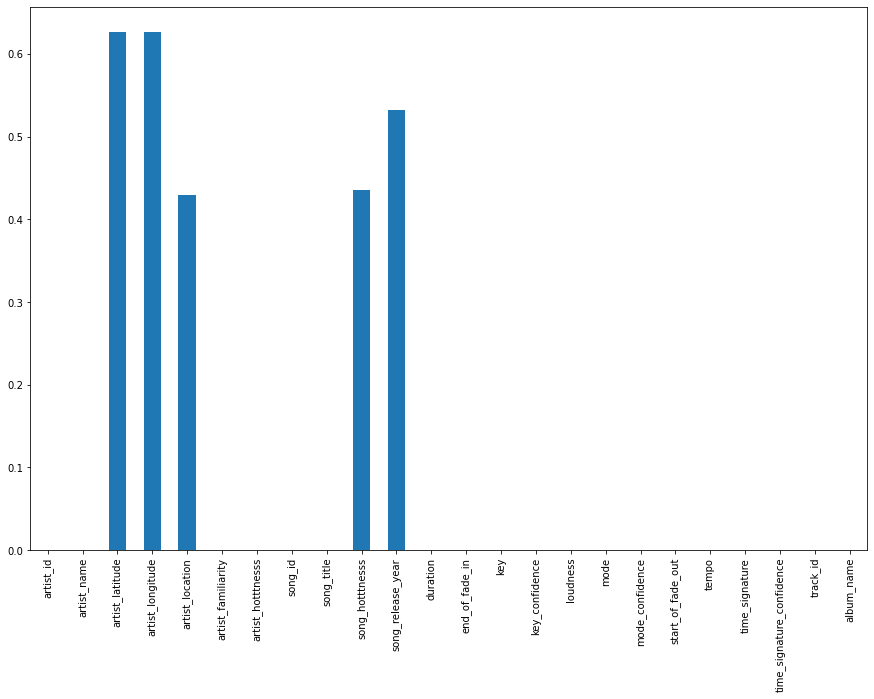

In [263]:
print(songs_copy.isna().sum())

(songs_copy.isna().sum() / songs_copy.shape[0]).plot(kind='bar', figsize=(15, 10));

<a id='54'></a>
### Step 5.4: Imputing missing values

#### Imputing artist familiarity

In [264]:
f_imp = SimpleImputer(missing_values=np.nan, strategy='median')
songs_copy['artist_familiarity'] = f_imp.fit_transform(songs_copy[['artist_familiarity']])
print('# of mising familiarity values:', songs_copy[['artist_familiarity']].isnull().sum())

# of mising familiarity values: artist_familiarity    0
dtype: int64


#### Imputing lat & lng

In [265]:
lat_lng_index = songs_copy[(songs_copy['artist_location'].notna()) & 
                           (songs_copy['artist_latitude'].isna()) & 
                            (songs_copy['artist_longitude'].isna())].index
songs_copy.loc[lat_lng_index]

,artist_id,artist_name,artist_latitude,artist_longitude,artist_location,artist_familiarity,artist_hotttnesss,song_id,song_title,song_hotttnesss,...,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_id,album_name
0,ARD7TVE1187B99BFB1,Casual,NaN,NaN,California - LA,0.581794,0.401998,SOMZWCG12A8C13C480,I Didn't Mean To,0.602120,...,0.736,-11.197,0.0,0.636,218.932007,92.197998,4.0,0.778,TRAAAAW128F429D538,Fear Itself
3,AR7G5I41187FB4CE6C,Adam Ant,NaN,NaN,"London, England",0.630382,0.454231,SONHOTT12A8C13493C,Something Girls,NaN,...,0.751,-9.013,1.0,0.749,217.123993,119.292999,4.0,0.000,TRAAAEF128F4273421,Friend Or Foe
6,ARD0S291187B9B7BF5,Rated R,NaN,NaN,Ohio,0.556496,0.261941,SOMJBYD12A6D4F8557,Keepin It Real (Skit),NaN,...,0.000,-17.302,1.0,0.000,114.781998,111.787003,1.0,0.000,TRAAAMQ128F1460CD3,Da Ghetto Psychic
7,AR10USD1187B99F3F1,Tweeterfriendly Music,NaN,NaN,"Burlington, Ontario, Canada",0.801136,0.605507,SOHKNRJ12A6701D1F8,Drop of Rain,NaN,...,0.000,-11.642,0.0,0.160,181.022995,101.430000,3.0,0.408,TRAAAPK128E0786D96,Gin & Phonic
11,ARC43071187B990240,Wayne Watson,NaN,NaN,"Wisner, LA",0.545159,0.351556,SOKEJEJ12A8C13E0D0,The Urgency (LP Version),0.265861,...,0.070,-7.545,1.0,0.686,227.479996,117.974998,4.0,0.835,TRAABCL128F4286650,The Way Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9976,ARJ8PZJ1187B99314F,Aiden,NaN,NaN,"Seattle, Washington",0.773491,0.500459,SOYYFNE12AB018A96D,Die Romantic [Live],0.472121,...,0.705,-7.561,1.0,0.617,236.279999,125.653000,4.0,1.000,TRBIHOC12903CE371C,From Hell...With Love
9978,ARNVM131187B990D2B,themselves,NaN,NaN,Oakland CA,0.628274,0.428835,SOLYUTF12A8C133225,Crayon Sharpener,0.428702,...,0.617,-13.017,1.0,0.545,267.726013,167.884995,4.0,0.465,TRBIHVW128F4233965,Them
9979,AR9UT8H1187B9AF504,Ivan Parker,NaN,NaN,Tennessee,0.384720,0.311097,SOVWTKI12A58A789B6,"Then He Said_ ""Sing",0.278598,...,0.938,-9.826,1.0,0.922,200.445999,91.963997,4.0,0.944,TRBIIAL128F4252C04,The Best Of Ivan Parker
9981,ARH9HS41187FB5BC6F,New Found Glory,NaN,NaN,"Coral Spring, FL",0.891854,0.548228,SOPHMRL12AB017E87B,Don't Let Her Pull You Down,0.663194,...,0.662,-3.301,1.0,0.658,191.279999,192.070007,4.0,0.937,TRBIIEU128F9307C88,Not Without A Fight


In [266]:
def jaccard(str1, str2, sep=',', threshold=0.7):
    """Compute the similarity between two locations."""
    str1 = str(str1).lower()
    str2 = str(str2).lower()
    
    for s2 in str2.split(sep):
        for s1 in str1.split():
            if len(set(s1).intersection(set(s2))) / len(set(s1).union(set(s2))) > threshold:
                return True
            else:
                return False

In [267]:
def impute_lat_lng(df, master_data, lat='artist_latitude', lng='artist_longitude', loc='artist_location', threshold=0.7):
    print('Before imputing # of mising lan&lon values:', df[[lat]].isnull().sum())
    
    null_lat_lng = df[((df[loc].notna()) & (df[lat].isnull()) & (df[lng].isnull()))]
    
    num_imp = 1
    for i, row in null_lat_lng.iterrows():
        loc1 = row[loc]
        for j, loc2 in (enumerate(master_data['location'])):
            if jaccard(str1=loc1, str2=loc2, threshold=threshold):
                df.iloc[i, 2] = master_data.iloc[j, 1]
                df.iloc[i, 3] = master_data.iloc[j, 2]
                sys.stdout.write("\rProgress: {} pair of missing lat&lng imputed".format(num_imp))
                sys.stdout.flush()
                num_imp += 1
                break

    print('\nAfter imputing # of mising lan&lon values:', df[[lat]].isnull().sum())  

In [268]:
# Impute with world cities master data
impute_lat_lng(songs_copy, world_cities)

Before imputing # of mising lan&lon values: artist_latitude    6258
dtype: int64
Progress: 1788 pair of missing lat&lng imputed
After imputing # of mising lan&lon values: artist_latitude    4470
dtype: int64


In [269]:
# Impute with us cities master data
impute_lat_lng(songs_copy, us_cities)

Before imputing # of mising lan&lon values: artist_latitude    4470
dtype: int64
Progress: 47 pair of missing lat&lng imputed
After imputing # of mising lan&lon values: artist_latitude    4423
dtype: int64


In [270]:
# Impute with world cities master data with lower jaccard threshold
impute_lat_lng(df=songs_copy, master_data=world_cities, threshold=0.5)

Before imputing # of mising lan&lon values: artist_latitude    4423
dtype: int64
Progress: 84 pair of missing lat&lng imputed
After imputing # of mising lan&lon values: artist_latitude    4339
dtype: int64


In [271]:
# Manually impute the rest
null_lat_lng = songs_copy[((songs_copy['artist_location'].notna()) 
                           & (songs_copy['artist_latitude'].isnull()) 
                           & (songs_copy['artist_longitude'].isnull()))]

print(set(null_lat_lng['artist_location']))

lat_lng_map = {'Mt. Vernon, NY': ['Mt. Vernon, New York, United States', 41.6484269, -74.4965475],
               'St. Catharines, ON, Canada': ['St. Catharines, Ontario, Canada', 43.17126, -79.24267],
               'Bézu, comme Superdupont, ne connait qu&#039;un pays : la France !': ['Paris, France', 48.85341, 2.3488],
               '台北, Taiwan': ['Taipei, Taiwan', 25.04776, 121.53185],
               'Taipei, Taiwan': ['Taipei, Taiwan', 25.04776, 121.53185],
               "St. Mary's, Jamaica": ['St. Mary Parish, Jamaica', 18.3166654, -76.8999964, ],
               'Havířov, Česká republika': ['Havířov, Česká republika', 49.784019, 18.433001],
               'St. Joseph, MO': ['St. Joseph, Missouri, United States', 38.936509, -94.604193],
               'St. Louis, Missouri': ['St. Louis, Missouri, United States', 38.62727, -90.19789],
               'St. Louis, MO': ['St. Louis, Missouri, United States', 38.62727, -90.19789]}

def map_lat_lng(df, loc, lat_lng_map):
    for l in lat_lng_map:
        for idx in df[df[loc] == l].index:
            df.iloc[idx, 2] = lat_lng_map[l][1]
            df.iloc[idx, 3] = lat_lng_map[l][2]
            df.iloc[idx, 4] = lat_lng_map[l][0]
            
map_lat_lng(songs_copy, 'artist_location', lat_lng_map)

{'Bézu, comme Superdupont, ne connait qu&#039;un pays : la France !', "St. Mary's, Jamaica", 'St. Catharines, ON, Canada', 'Havířov, Česká republika', 'St. Joseph, MO', 'Mt. Vernon, NY', 'St. Louis, Missouri', 'St. Louis, MO', '台北, Taiwan'}


In [272]:
# Sanity check
songs_copy.loc[lat_lng_index]

,artist_id,artist_name,artist_latitude,artist_longitude,artist_location,artist_familiarity,artist_hotttnesss,song_id,song_title,song_hotttnesss,...,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_id,album_name
0,ARD7TVE1187B99BFB1,Casual,41.440899,-82.183998,California - LA,0.581794,0.401998,SOMZWCG12A8C13C480,I Didn't Mean To,0.602120,...,0.736,-11.197,0.0,0.636,218.932007,92.197998,4.0,0.778,TRAAAAW128F429D538,Fear Itself
3,AR7G5I41187FB4CE6C,Adam Ant,51.500000,-0.116700,"London, England",0.630382,0.454231,SONHOTT12A8C13493C,Something Girls,NaN,...,0.751,-9.013,1.0,0.749,217.123993,119.292999,4.0,0.000,TRAAAEF128F4273421,Friend Or Foe
6,ARD0S291187B9B7BF5,Rated R,4.600000,101.065002,Ohio,0.556496,0.261941,SOMJBYD12A6D4F8557,Keepin It Real (Skit),NaN,...,0.000,-17.302,1.0,0.000,114.781998,111.787003,1.0,0.000,TRAAAMQ128F1460CD3,Da Ghetto Psychic
7,AR10USD1187B99F3F1,Tweeterfriendly Music,36.076199,-79.468697,"Burlington, Ontario, Canada",0.801136,0.605507,SOHKNRJ12A6701D1F8,Drop of Rain,NaN,...,0.000,-11.642,0.0,0.160,181.022995,101.430000,3.0,0.408,TRAAAPK128E0786D96,Gin & Phonic
11,ARC43071187B990240,Wayne Watson,36.145599,-82.411598,"Wisner, LA",0.545159,0.351556,SOKEJEJ12A8C13E0D0,The Urgency (LP Version),0.265861,...,0.070,-7.545,1.0,0.686,227.479996,117.974998,4.0,0.835,TRAABCL128F4286650,The Way Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9976,ARJ8PZJ1187B99314F,Aiden,47.621101,-122.324402,"Seattle, Washington",0.773491,0.500459,SOYYFNE12AB018A96D,Die Romantic [Live],0.472121,...,0.705,-7.561,1.0,0.617,236.279999,125.653000,4.0,1.000,TRBIHOC12903CE371C,From Hell...With Love
9978,ARNVM131187B990D2B,themselves,28.477200,-81.336899,Oakland CA,0.628274,0.428835,SOLYUTF12A8C133225,Crayon Sharpener,0.428702,...,0.617,-13.017,1.0,0.545,267.726013,167.884995,4.0,0.465,TRBIHVW128F4233965,Them
9979,AR9UT8H1187B9AF504,Ivan Parker,51.450001,7.016600,Tennessee,0.384720,0.311097,SOVWTKI12A58A789B6,"Then He Said_ ""Sing",0.278598,...,0.938,-9.826,1.0,0.922,200.445999,91.963997,4.0,0.944,TRBIIAL128F4252C04,The Best Of Ivan Parker
9981,ARH9HS41187FB5BC6F,New Found Glory,-12.070000,-77.135002,"Coral Spring, FL",0.891854,0.548228,SOPHMRL12AB017E87B,Don't Let Her Pull You Down,0.663194,...,0.662,-3.301,1.0,0.658,191.279999,192.070007,4.0,0.937,TRBIIEU128F9307C88,Not Without A Fight


In [273]:
songs_copy.isna().sum()

artist_id                       0
artist_name                     0
artist_latitude              4295
artist_longitude             4295
artist_location              4295
artist_familiarity              0
artist_hotttnesss               0
song_id                         0
song_title                      1
song_hotttnesss              4352
song_release_year            5320
duration                        0
end_of_fade_in                  0
key                             0
key_confidence                  0
loudness                        0
mode                            0
mode_confidence                 0
start_of_fade_out               0
tempo                           0
time_signature                  0
time_signature_confidence       0
track_id                        0
album_name                      0
dtype: int64

#### Impute song release year

In [51]:
songs_year_na = songs_copy[songs_copy['song_release_year'].isnull()]
songs_year_na[['artist_name', 'song_title', 'song_release_year']]

,artist_name,song_title,song_release_year
0,Casual,I Didn't Mean To,NaN
2,Sonora Santanera,Amor De Cabaret,NaN
5,Jeff And Sheri Easter,The Moon And I (Ordinary Day Album Version),NaN
6,Rated R,Keepin It Real (Skit),NaN
7,Tweeterfriendly Music,Drop of Rain,NaN
...,...,...,...
9990,Diamanda Galas,Dark End Of The Street,NaN
9992,Mario Rosenstock,Munster Song (Best of 2009),NaN
9993,Grandpa Jones,Down In Dixie,NaN
9997,Winston Reedy,Sentimental Man,NaN


In [52]:
predicted_cols = ['duration', 
                  'end_of_fade_in', 
                  'key','key_confidence', 
                  'loudness', 
                  'mode', 
                  'mode_confidence',
                  'start_of_fade_out', 
                  'tempo', 
                  'time_signature',
                  'time_signature_confidence']

X = songs_copy[predicted_cols]

# Standardize the data
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

nbrs = NearestNeighbors(n_neighbors=20, algorithm='auto').fit(X)
_, indices = nbrs.kneighbors(X)
for i, row in songs_year_na.iterrows():
    for j in indices[i, 1:]:
        if j not in songs_year_na.index:
            songs_copy.iloc[i, 10] = songs_copy.iloc[j, 10]
            
songs_copy['song_release_year'] = songs_copy['song_release_year'].astype('int32')
songs_copy.loc[songs_year_na.index][['artist_name', 'song_title', 'song_release_year']]

,artist_name,song_title,song_release_year
0,Casual,I Didn't Mean To,2006
2,Sonora Santanera,Amor De Cabaret,1991
5,Jeff And Sheri Easter,The Moon And I (Ordinary Day Album Version),2000
6,Rated R,Keepin It Real (Skit),2003
7,Tweeterfriendly Music,Drop of Rain,2000
...,...,...,...
9990,Diamanda Galas,Dark End Of The Street,1996
9992,Mario Rosenstock,Munster Song (Best of 2009),1994
9993,Grandpa Jones,Down In Dixie,2008
9997,Winston Reedy,Sentimental Man,2007


In [53]:
print(songs_copy.isna().sum())

artist_id                       0
artist_name                     0
artist_latitude              4295
artist_longitude             4295
artist_location              4295
artist_familiarity              0
artist_hotttnesss               0
song_id                         0
song_title                      1
song_hotttnesss              4352
song_release_year               0
duration                        0
end_of_fade_in                  0
key                             0
key_confidence                  0
loudness                        0
mode                            0
mode_confidence                 0
start_of_fade_out               0
tempo                           0
time_signature                  0
time_signature_confidence       0
track_id                        0
album_name                      0
dtype: int64


#### Impute song hotttnesss

In [54]:
songs_hot_na = songs_copy[songs_copy['song_hotttnesss'].isnull()]
songs_hot_na[['artist_name', 'song_title', 'song_release_year', 'song_hotttnesss']]

,artist_name,song_title,song_release_year,song_hotttnesss
1,The Box Tops,Soul Deep,1969,NaN
2,Sonora Santanera,Amor De Cabaret,1991,NaN
3,Adam Ant,Something Girls,1982,NaN
5,Jeff And Sheri Easter,The Moon And I (Ordinary Day Album Version),2000,NaN
6,Rated R,Keepin It Real (Skit),2003,NaN
...,...,...,...,...
9987,Chantal Chamandy,Zindegi,2000,NaN
9989,It Dies Today,One the road (to Damnation),2006,NaN
9992,Mario Rosenstock,Munster Song (Best of 2009),1994,NaN
9994,Blind Willie Johnson,God Don't Never Change,1989,NaN


In [55]:
for i, row in songs_hot_na.iterrows():
    for j in indices[i, 1:]:
        if j not in songs_hot_na.index:
            songs_copy.iloc[i, 9] = songs_copy.iloc[j, 9]
            
songs_copy.loc[songs_hot_na.index][['artist_name', 'song_title', 'song_release_year', 'song_hotttnesss']]

,artist_name,song_title,song_release_year,song_hotttnesss
1,The Box Tops,Soul Deep,1969,0.000000
2,Sonora Santanera,Amor De Cabaret,1991,0.000000
3,Adam Ant,Something Girls,1982,0.265861
5,Jeff And Sheri Easter,The Moon And I (Ordinary Day Album Version),2000,0.392009
6,Rated R,Keepin It Real (Skit),2003,0.419674
...,...,...,...,...
9987,Chantal Chamandy,Zindegi,2000,0.506271
9989,It Dies Today,One the road (to Damnation),2006,0.788388
9992,Mario Rosenstock,Munster Song (Best of 2009),1994,0.000000
9994,Blind Willie Johnson,God Don't Never Change,1989,0.000000


In [56]:
songs_copy.isna().sum()

artist_id                       0
artist_name                     0
artist_latitude              4295
artist_longitude             4295
artist_location              4295
artist_familiarity              0
artist_hotttnesss               0
song_id                         0
song_title                      1
song_hotttnesss                 0
song_release_year               0
duration                        0
end_of_fade_in                  0
key                             0
key_confidence                  0
loudness                        0
mode                            0
mode_confidence                 0
start_of_fade_out               0
tempo                           0
time_signature                  0
time_signature_confidence       0
track_id                        0
album_name                      0
dtype: int64

<a id='6'></a>
## Step 6: Load the clean dataset

In [57]:
# Save as csv format
songs_copy.to_csv('data/songs_subset_clean.csv', index=False)

# Save as db format
engine = create_engine('sqlite:///data/songs_subset.db')
songs_copy.to_sql('songs_subset_clean',engine, if_exists='replace')